<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install --quiet pmdarima

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Getting the data

In [5]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [6]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [7]:
FIGSIZE = (20, 20)

In [8]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [9]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [10]:
dataset.shape

(346507, 2)

In [11]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [12]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [13]:
dataset.isnull().sum()

,0
date_time,0
level_cm,0


In [14]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [15]:
dataset.dtypes

,0
level_cm,int64


# Time Series EDA

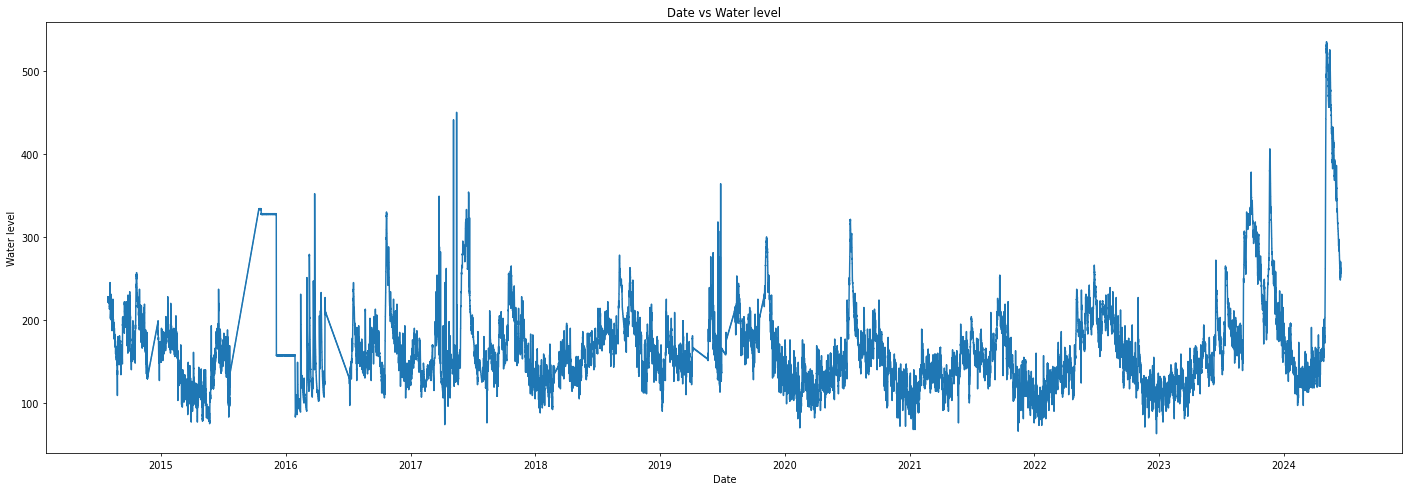

In [16]:
plot_dataset(dataset.index, dataset['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Selecting time

In [17]:
# Definir a faixa de datas
start_date = '2020-01-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

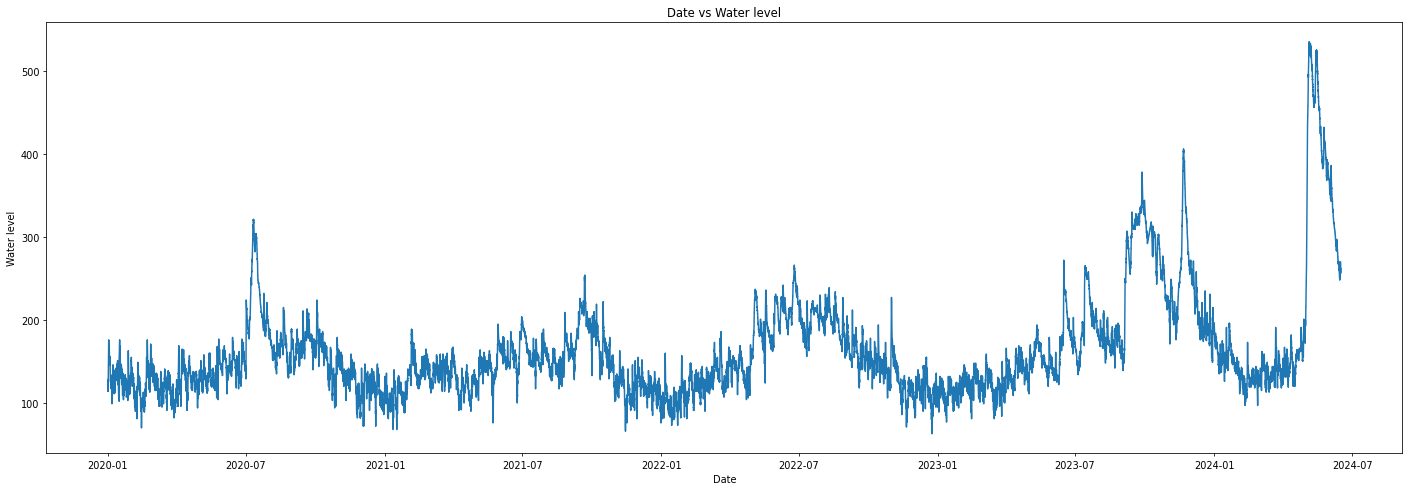

In [18]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Grouping the data by day

In [19]:
df_daily_mean = df_filtered.resample('D').mean()
df_daily_mean

,level_cm
date_time,
2020-01-01,133.281250
2020-01-02,168.656250
2020-01-03,152.645833
2020-01-04,131.593750
2020-01-05,125.791667
...,...
2024-06-12,270.854167
2024-06-13,263.791667
2024-06-14,252.802083


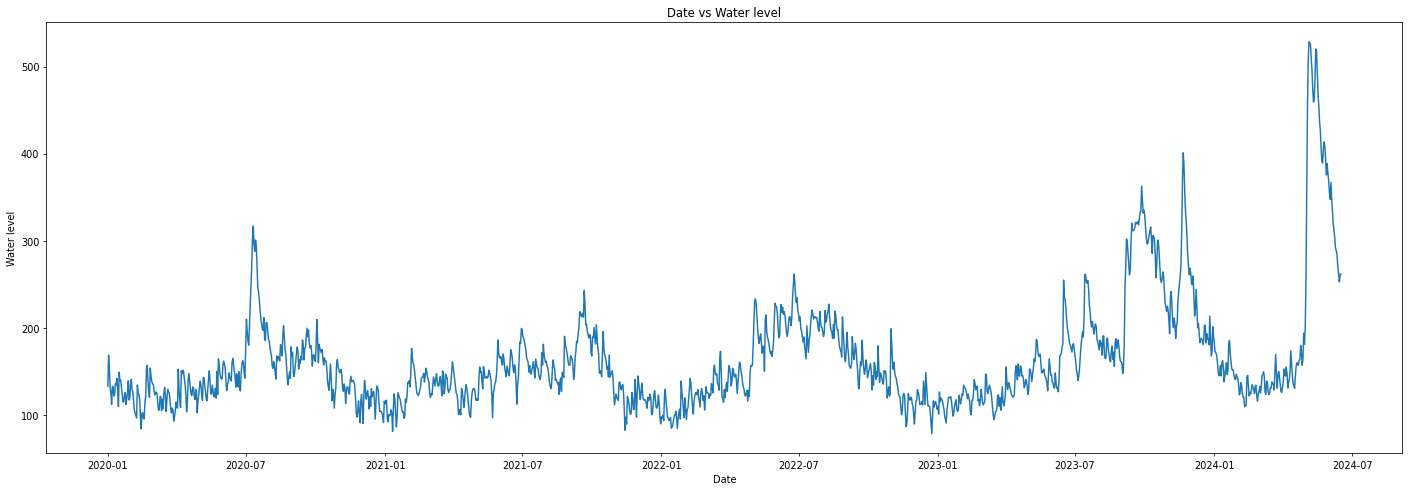

In [126]:
plot_dataset(df_daily_mean.index, df_daily_mean['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

## Time Series Decomposition

In [20]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

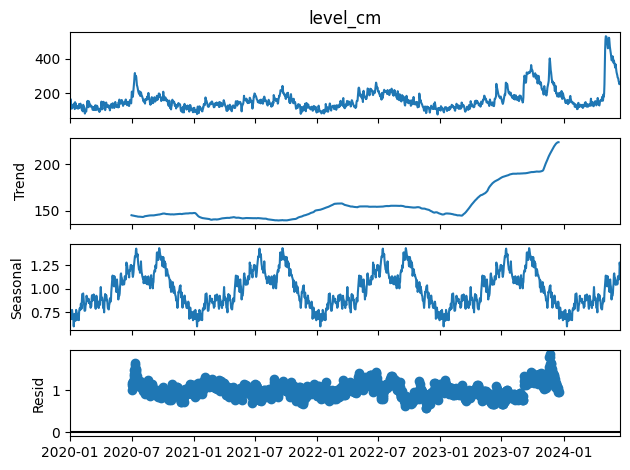

In [21]:
result = seasonal_decompose(df_daily_mean['level_cm'], model='multiplicative', period=365)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

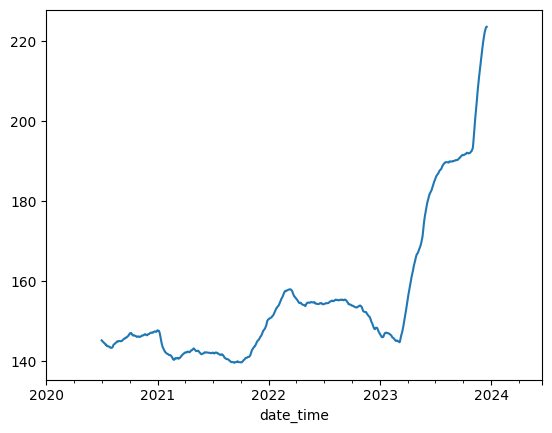

In [22]:
result.trend.plot()

<Axes: xlabel='date_time'>

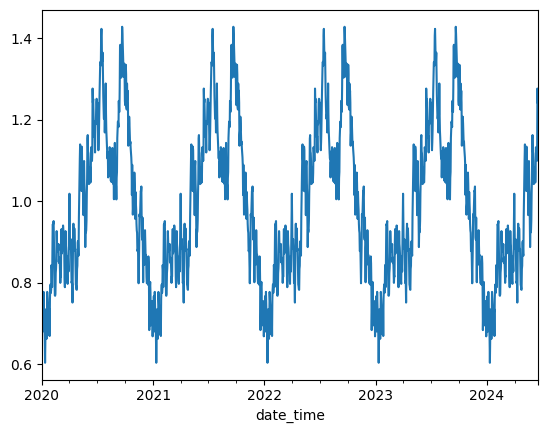

In [23]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

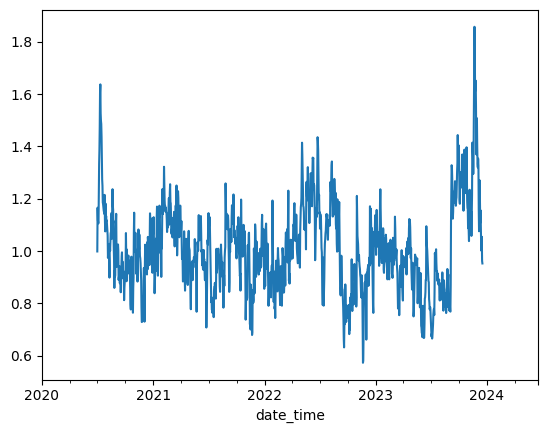

In [24]:
residual = result.resid
residual.plot()

## Making the series stationary

In [25]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [26]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [27]:
print("Level_cm")
check_stationarity(df_daily_mean['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.273927
p-value: 0.000493
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


### Transforming data

In [28]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_daily_mean['level_cm'] - df_daily_mean['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2020-01-02,35.375000
2020-01-03,-16.010417
2020-01-04,-21.052083
2020-01-05,-5.802083
2020-01-06,-13.593750
...,...
2024-06-12,-12.781250
2024-06-13,-7.062500
2024-06-14,-10.989583


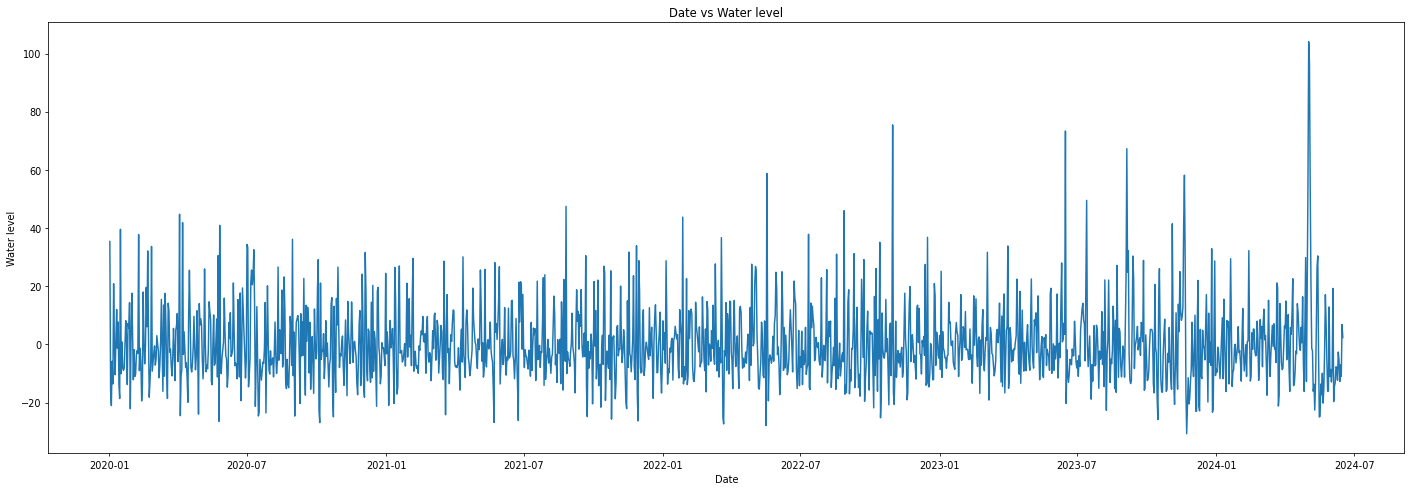

In [29]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [30]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -29.888928
p-value: 0.000000
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


**Using ACF and PACF level_cm**

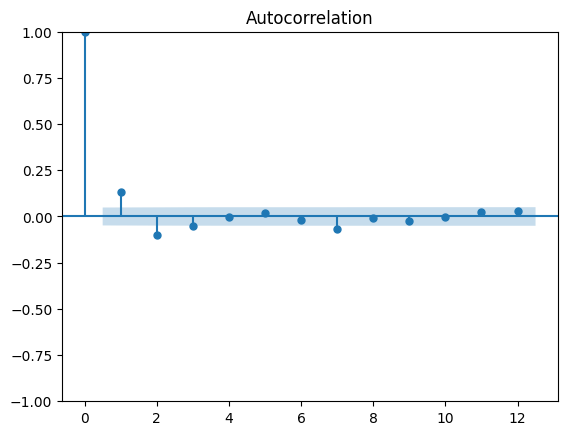

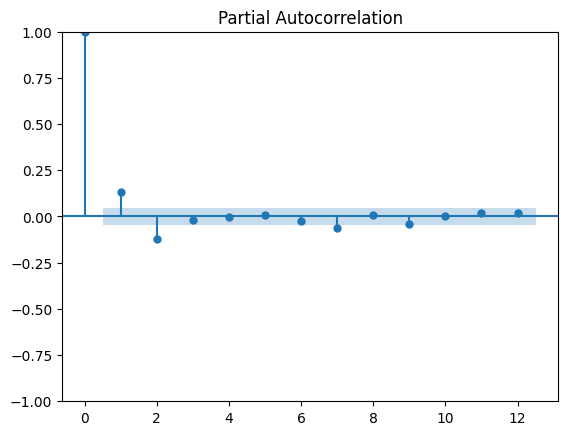

In [31]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

# Training the model

## Scaling the data

In [32]:
data = df_lag['level_cm_lag_1'].values
data

array([ 35.375     , -16.01041667, -21.05208333, ..., -10.98958333,
         6.83333333,   2.36458333])

In [33]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
# data_scaled

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_lag).flatten()
data_scaled

array([0.49033854, 0.10905859, 0.0716494 , ..., 0.14631319, 0.27855928,
       0.24540114])

In [35]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] = data_scaled
df_scaled.index = df_lag.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


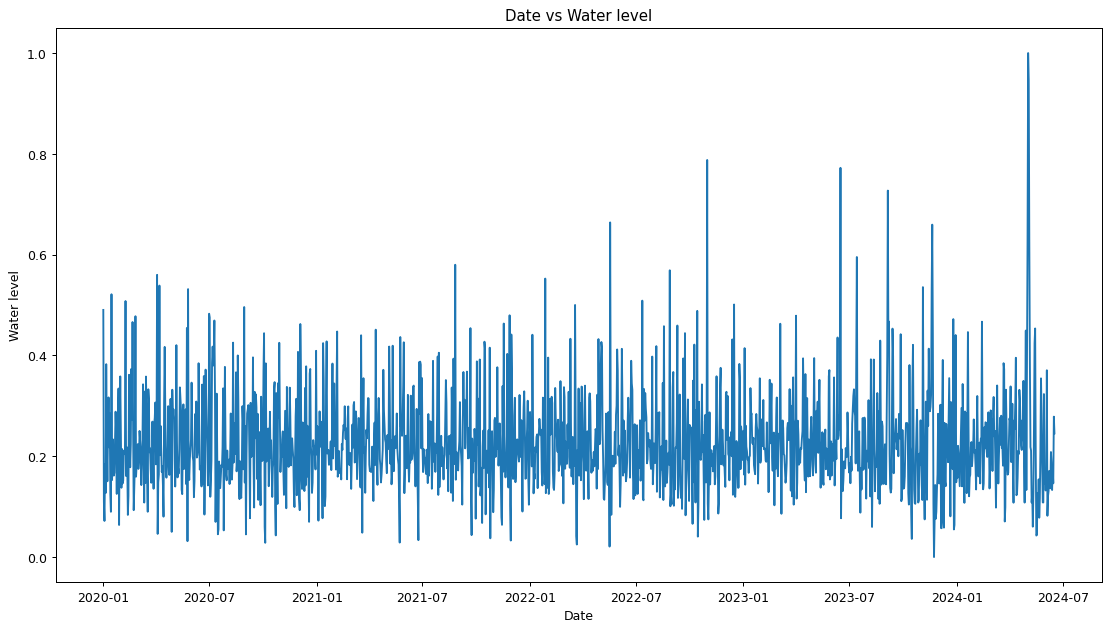

In [36]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [37]:
start_date_train = '2023-01-01'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

train_size = len(df_train)
test_size = len(df_test)

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  1096
Test size:  533


In [38]:
# 67%
df_scaled.head(1091)

# 70% --> selecionado
df_scaled.head(1139)

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2023-02-09,0.188978
2023-02-10,0.267197
2023-02-11,0.190679


In [39]:
df_train

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2022-12-28,0.259004
2022-12-29,0.243933
2022-12-30,0.199722


In [40]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-02,0.163627
2023-01-03,0.414515
2023-01-04,0.143685
2023-01-05,0.260550
2023-01-06,0.219045
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


## AUTO ARIMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1,
                   start_q=1,
                   max_p=2,
                   max_q=2,
                   start_P=1,
                   start_Q=1,
                   D=0,
                   max_P=3,
                   max_D=3,
                   max_Q=3,
                   max_order=5,
                   m=365,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[365] intercept   : AIC=inf, Time=1754.89 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=-2063.844, Time=0.14 sec


KeyboardInterrupt: 

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

In [ ]:
forecast.values

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['level_cm_lag_1_scaled'])
plt.plot(df_test.index, forecast.values, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Undoing the scale transformation

In [ ]:
forecast = forecast.values
test_data = np.array(df_test['level_cm_lag_1_scaled'])

forecast_inversed = scaler.inverse_transform(forecast.reshape(0, 1))
test_inversed = scaler.inverse_transform(test_data.reshape(0, 1))

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, test_inversed)
plt.plot(df_test.index, forecast_inversed, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Calculating error

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
print("MSE: ", mean_squared_error(test_inversed, forecast_inversed))

In [ ]:
print("RMSE: ", root_mean_squared_error(test_inversed, forecast_inversed))

##LSTM

###Primeiro modelo

Converting test and training to numpy arrays

In [41]:
df_train_array = np.array(df_train.values)
df_test_array = np.array(df_test.values)

In [42]:
df_train_array.size

1096

In [43]:
df_train_array

array([[0.49033854],
       [0.10905859],
       [0.0716494 ],
       ...,
       [0.19972175],
       [0.19268821],
       [0.2504251 ]])

Creating the entry set, mini-batches

#### Dividindo os dados em 180 x 31

In [44]:
import numpy as np

def create_lstm_datasets(dataset, train_size=181, val_size=31):
    x, y = [], []

    for i in range(len(dataset) - train_size - val_size):
        x_segment = dataset[i:(i + train_size)]
        y_segment = dataset[(i + train_size):(i + train_size + val_size)]

        x.append(x_segment)
        y.append(y_segment)

    return np.array(x), np.array(y)

In [45]:
train_size = 5
val_size = 1

train_x, train_y = create_lstm_datasets(df_train_array, train_size, val_size)
test_x, test_y = create_lstm_datasets(df_test_array,  train_size, val_size)

In [46]:
print("Shape de x:", train_x.shape)
print("Shape de y:", train_y.shape)

Shape de x: (1090, 5, 1)
Shape de y: (1090, 1, 1)


In [47]:
print("Shape de x:", test_x.shape)
print("Shape de y:", test_y.shape)

Shape de x: (526, 5, 1)
Shape de y: (526, 1, 1)


[samples, time steps, features]

In [48]:
np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1])).shape

(1090, 1, 5)

In [ ]:
# # reshape input to be [samples, time steps, features]
# train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
# test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [49]:
train_x.shape

(1090, 5, 1)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

batch_size = 32
epochs = 20

# Definindo o modelo
model = Sequential()

# Adicionando a camada LSTM com função de ativação tanh
model.add(LSTM(4, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))

# Adicionando a camada Dropout para regularização
# model.add(Dropout(0.2))

# Adicionando a camada de saída com função de ativação tanh
model.add(Dense(1, activation='relu'))

# Compilando o modelo com função de perda e otimizador
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinando o modelo
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 - 1s - 35ms/step - loss: 0.0194
Epoch 2/20
35/35 - 0s - 3ms/step - loss: 0.0100
Epoch 3/20
35/35 - 0s - 3ms/step - loss: 0.0097
Epoch 4/20
35/35 - 0s - 3ms/step - loss: 0.0097
Epoch 5/20
35/35 - 0s - 4ms/step - loss: 0.0096
Epoch 6/20
35/35 - 0s - 3ms/step - loss: 0.0096
Epoch 7/20
35/35 - 0s - 3ms/step - loss: 0.0096
Epoch 8/20
35/35 - 0s - 3ms/step - loss: 0.0095
Epoch 9/20
35/35 - 0s - 3ms/step - loss: 0.0095
Epoch 10/20
35/35 - 0s - 3ms/step - loss: 0.0095
Epoch 11/20
35/35 - 0s - 3ms/step - loss: 0.0094
Epoch 12/20
35/35 - 0s - 3ms/step - loss: 0.0094
Epoch 13/20
35/35 - 0s - 3ms/step - loss: 0.0094
Epoch 14/20
35/35 - 0s - 3ms/step - loss: 0.0093
Epoch 15/20
35/35 - 0s - 3ms/step - loss: 0.0093
Epoch 16/20
35/35 - 0s - 3ms/step - loss: 0.0094
Epoch 17/20
35/35 - 0s - 3ms/step - loss: 0.0092
Epoch 18/20
35/35 - 0s - 3ms/step - loss: 0.0092
Epoch 19/20
35/35 - 0s - 4ms/step - loss: 0.0092
Epoch 20/20
35/35 - 0s - 3ms/step - loss: 0.0093


make predictions

In [61]:
# make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [62]:
train_predict.shape

(1090, 1)

In [63]:
test_predict.shape

(526, 1)

invert predictions

In [64]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_y_normal = scaler.inverse_transform(df_train_array)

test_predict = scaler.inverse_transform(test_predict)
test_y_normal = scaler.inverse_transform(df_test_array)

calculate root mean squared error

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(train_y_normal, train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_y_normal, test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: Found input variables with inconsistent numbers of samples: [1096, 884]

In [65]:
print("Test size:", len(test_y_normal))
print("Predicted size:", len(test_predict))

Test size: 532
Predicted size: 526


In [66]:
print("Train size:", len(train_y_normal))
print("Predicted size:", len(train_predict))

Train size: 1096
Predicted size: 1090


In [67]:
index_train = np.arange(0, len(train_predict))
index_train_normal = np.arange(0, len(train_y_normal))
index_test_normal = np.arange(0, len(test_y_normal))
index_test = np.arange(0, len(test_predict))

Text(0.5, 1.0, 'Forecast using LSTM - Test')

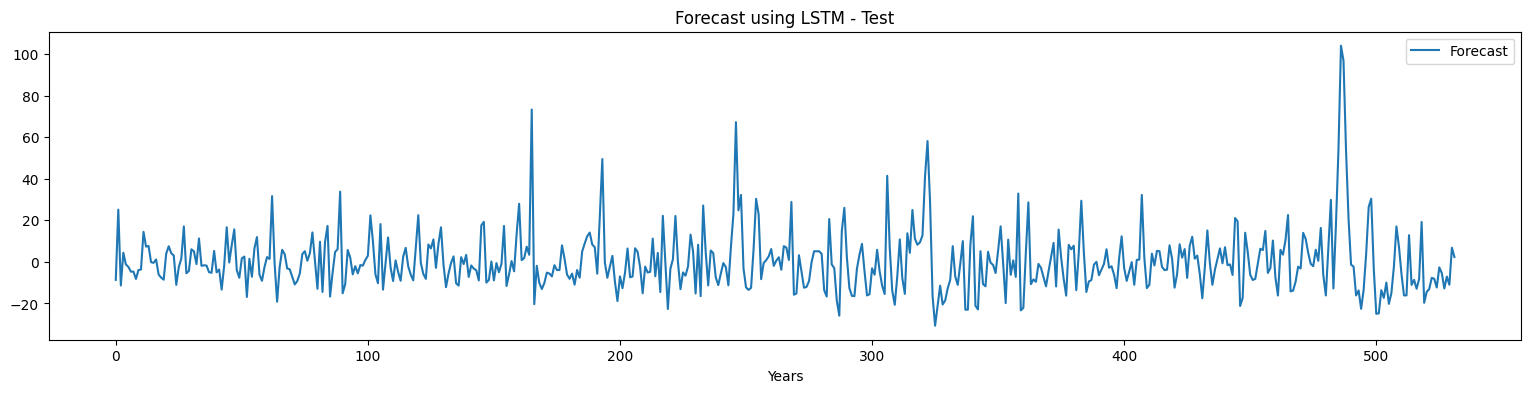

In [68]:
plt.figure(figsize=(19, 4))
plt.plot(index_test_normal, test_y_normal)
#plt.plot(index_test, test_predict, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using LSTM - Test")

Text(0.5, 1.0, 'Forecast using LSTM - Test')

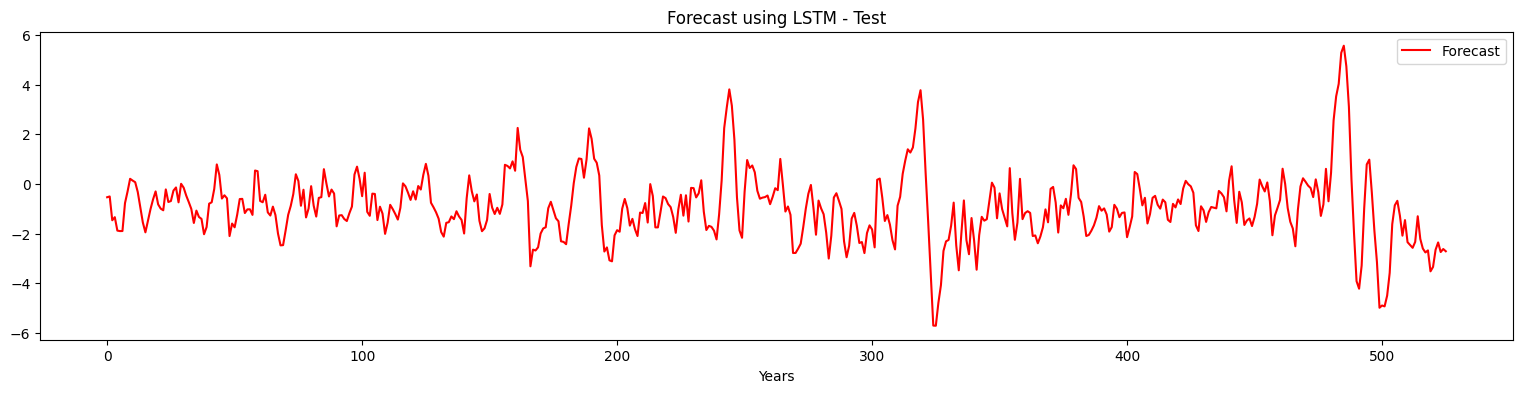

In [69]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, test_predict, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using LSTM - Test")

Text(0.5, 1.0, 'Forecast using LSTM - Test')

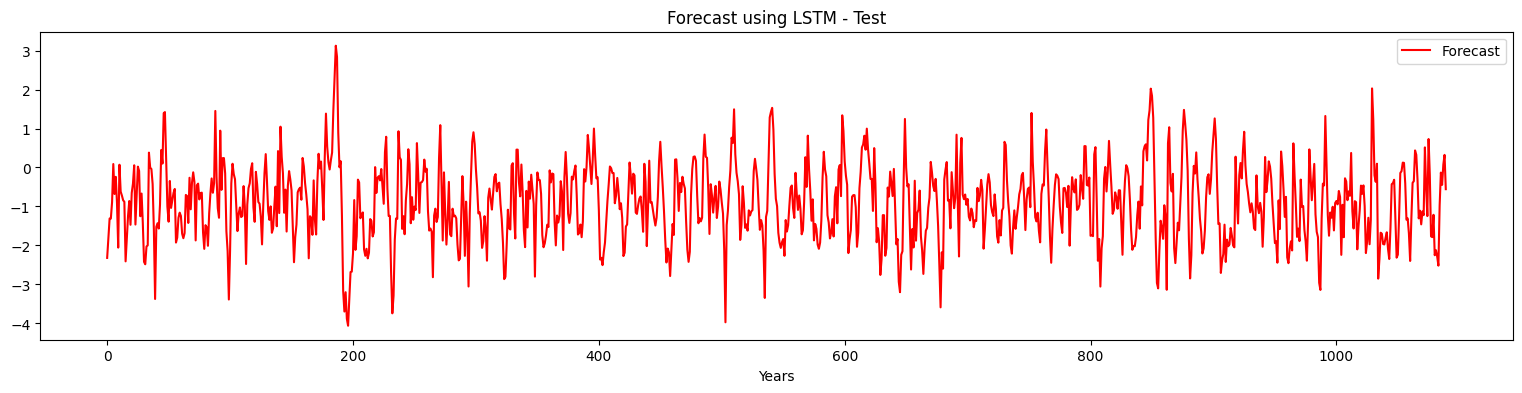

In [70]:
plt.figure(figsize=(19, 4))
# plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, train_predict, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using LSTM - Test")

Dados deslocados

In [ ]:
import numpy as np

# Supondo que train_predict é o array retornado pelo modelo LSTM com shape (884, 1)
train_predict = train_predict  # Substitua isso pelas predições reais do seu modelo

# Inicializar a sequência ajustada com zeros
adjusted_predictions = np.zeros((1096, 1))

# Preencher as predições nas posições corretas
for i in range(884):
    adjusted_predictions[i + 181] = train_predict[i]

print("Shape das predições ajustadas:", adjusted_predictions.shape)
print("Predições ajustadas:", adjusted_predictions.flatten())


####Inverse transform

In [ ]:
plt.figure(figsize=(19, 4))
# plt.plot(index_test_normal, test_y_normal)
plt.plot(df_train.index, adjusted_predictions, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using LSTM - Test")

In [ ]:
import numpy as np

# Supondo que train_predict é o array retornado pelo modelo LSTM com shape (884, 1)
test_predict = test_predict  # Substitua isso pelas predições reais do seu modelo

# Inicializar a sequência ajustada com zeros
adjusted_predictions = np.zeros((532, 1))

# Preencher as predições nas posições corretas
for i in range(320):
    adjusted_predictions[i + 31] = train_predict[i]

print("Shape das predições ajustadas:", adjusted_predictions.shape)
print("Predições ajustadas:", adjusted_predictions.flatten())


In [ ]:
plt.figure(figsize=(19, 4))
# plt.plot(index_test_normal, test_y_normal)
plt.plot(df_test.index, adjusted_predictions, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using LSTM - Test")

###Segundo Modelo

In [71]:
df_scaled.values.shape

(1628, 1)

In [72]:
df_lag['level_cm_lag_1'].values.reshape(-1, 1).shape

(1628, 1)

In [73]:
input_data = df_lag['level_cm_lag_1'].values.reshape(-1, 1)

In [75]:
import numpy as np

def create_dataset(dataset, look_back=5):
    x, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)

# Criar o conjunto de dados com janelas
look_back = 5
x, y = create_dataset(df_scaled.values, look_back)

# Reshape para [samples, time steps, features]
x = np.reshape(x, (x.shape[0], look_back, 1))

print("Shape de x:", x.shape)  # (914, 181, 1)
print("Shape de y:", y.shape)  # (914,)


Shape de x: (1622, 5, 1)
Shape de y: (1622,)


In [76]:
# Dividir os dados em treinamento e validação
train_size = int(len(x) * 0.8)
test_size = len(x) - train_size
x_train, x_test = x[0:train_size], x[train_size:len(x)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [77]:
print("X:", x_train.shape)
print("Y:", y_train.shape)

X: (1297, 5, 1)
Y: (1297,)


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

batch_size = 32
epochs = 20

# Definindo o modelo
model = Sequential()

# Adicionando a camada LSTM com função de ativação tanh
model.add(LSTM(2, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))

# Adicionando a camada Dropout para regularização
# model.add(Dropout(0.2))

# Adicionando a camada de saída com função de ativação tanh
model.add(Dense(1, activation='relu'))

# Compilando o modelo com função de perda e otimizador
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0210 - val_accuracy: 0.0031 - val_loss: 0.0160
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0112 - val_accuracy: 0.0031 - val_loss: 0.0139
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0031 - val_loss: 0.0138
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0095 - val_accuracy: 0.0031 - val_loss: 0.0138
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0092 - val_accuracy: 0.0031 - val_loss: 0.0139
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0031 - val_loss: 0.0139
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0087 - val_accuracy: 0.0031 - val_loss: 0.0139
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0093 - val_accurac

In [95]:
# Fazer predições
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Formato das predições
print("Shape de train_predict:", train_predict.shape)  # (731, 1)
print("Shape de test_predict:", test_predict.shape)    # (183, 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shape de train_predict: (1297, 1)
Shape de test_predict: (325, 1)


In [96]:
# Calcular RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.09 RMSE
Test Score: 0.12 RMSE


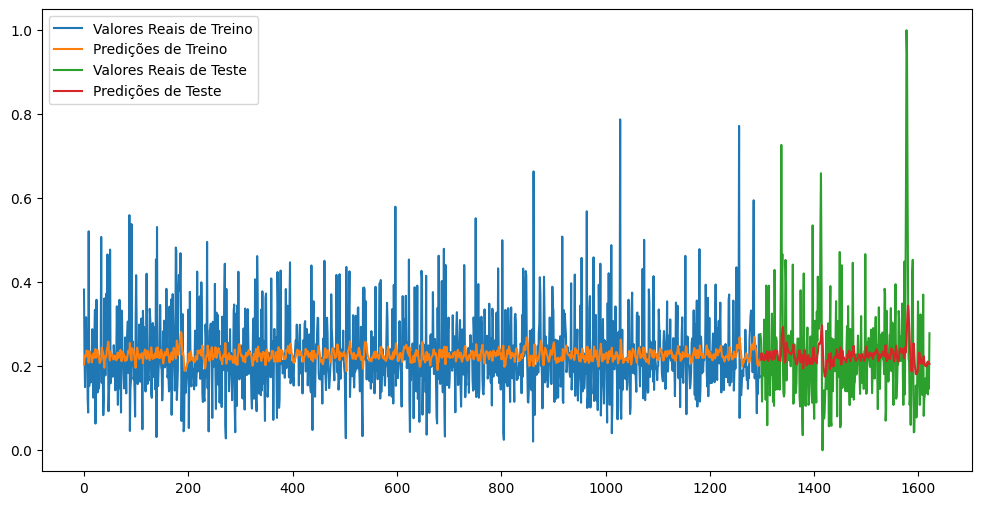

In [97]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Plotar predições e valores reais
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Valores Reais de Treino')
plt.plot(range(len(train_predict)), train_predict, label='Predições de Treino')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Valores Reais de Teste')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predições de Teste')
plt.legend()
plt.show()


### LSTM - Non-stationary data

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_daily_mean.values)
data_scaled

array([[0.12149771],
       [0.2001343 ],
       [0.16454407],
       ...,
       [0.38718566],
       [0.40237577],
       [0.4076321 ]])

In [43]:
data_scaled.shape

(1629, 1)

In [44]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1303
Teste: 326


In [45]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [46]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [47]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.12149771 0.2001343  0.16454407 0.11774649 0.10484879] 0.07463066734589913
[0.2001343  0.16454407 0.11774649 0.10484879 0.07463067] 0.12101143889223356
[0.16454407 0.11774649 0.10484879 0.07463067 0.12101144] 0.11913583105636086
[0.11774649 0.10484879 0.07463067 0.12101144 0.11913583] 0.09593386745704627
[0.10484879 0.07463067 0.12101144 0.11913583 0.09593387] 0.10065762052517016


In [48]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1297, 5)
Train Y shape:  (1297,)


In [49]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (320, 5)
Test Y shape:  (320,)


In [51]:
trainX.shape

(1297, 5)

In [53]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1297, 5, 1)

In [54]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [58]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1297/1297 - 4s - 3ms/step - loss: 0.0043
Epoch 2/100
1297/1297 - 2s - 2ms/step - loss: 0.0015
Epoch 3/100
1297/1297 - 2s - 2ms/step - loss: 0.0014
Epoch 4/100
1297/1297 - 2s - 2ms/step - loss: 0.0013
Epoch 5/100
1297/1297 - 2s - 2ms/step - loss: 0.0013
Epoch 6/100
1297/1297 - 3s - 2ms/step - loss: 0.0012
Epoch 7/100
1297/1297 - 3s - 2ms/step - loss: 0.0012
Epoch 8/100
1297/1297 - 3s - 2ms/step - loss: 0.0011
Epoch 9/100
1297/1297 - 3s - 2ms/step - loss: 0.0011
Epoch 10/100
1297/1297 - 2s - 2ms/step - loss: 0.0010
Epoch 11/100
1297/1297 - 2s - 2ms/step - loss: 9.1824e-04
Epoch 12/100
1297/1297 - 3s - 2ms/step - loss: 8.4069e-04
Epoch 13/100
1297/1297 - 3s - 2ms/step - loss: 8.1272e-04
Epoch 14/100
1297/1297 - 2s - 2ms/step - loss: 7.9435e-04
Epoch 15/100
1297/1297 - 2s - 2ms/step - loss: 7.9040e-04
Epoch 16/100
1297/1297 - 3s - 2ms/step - loss: 7.6452e-04
Epoch 17/100
1297/1297 - 2s - 2ms/step - loss: 7.6587e-04
Epoch 18/100
1297/1297 - 2s - 2ms/step - loss: 7.6068e-04
Epoch

Predição

In [59]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [60]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [61]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 11.91 RMSE
Test Score: 16.57 RMSE


In [64]:
index_train = np.arange(0, len(trainPredict))
index_train_normal = np.arange(0, len(trainY))
index_test_normal = np.arange(0, len(testY))
index_test = np.arange(0, len(testPredict))

Text(0.5, 1.0, 'Forecast using Train data')

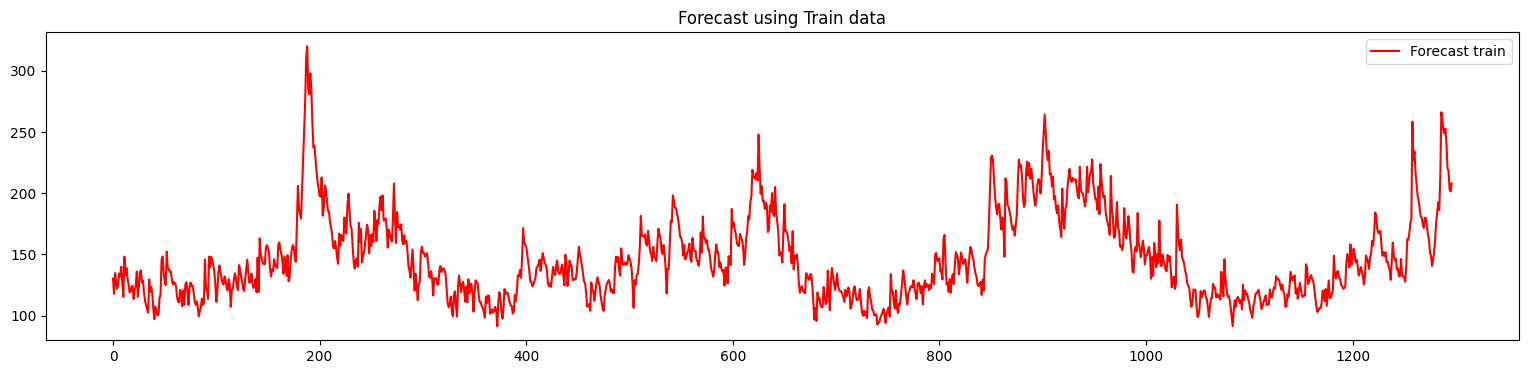

In [129]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, trainPredict, 'red')
plt.legend(["Forecast train"])
plt.title("Forecast using Train data")

Text(0.5, 1.0, 'Forecast using test data')

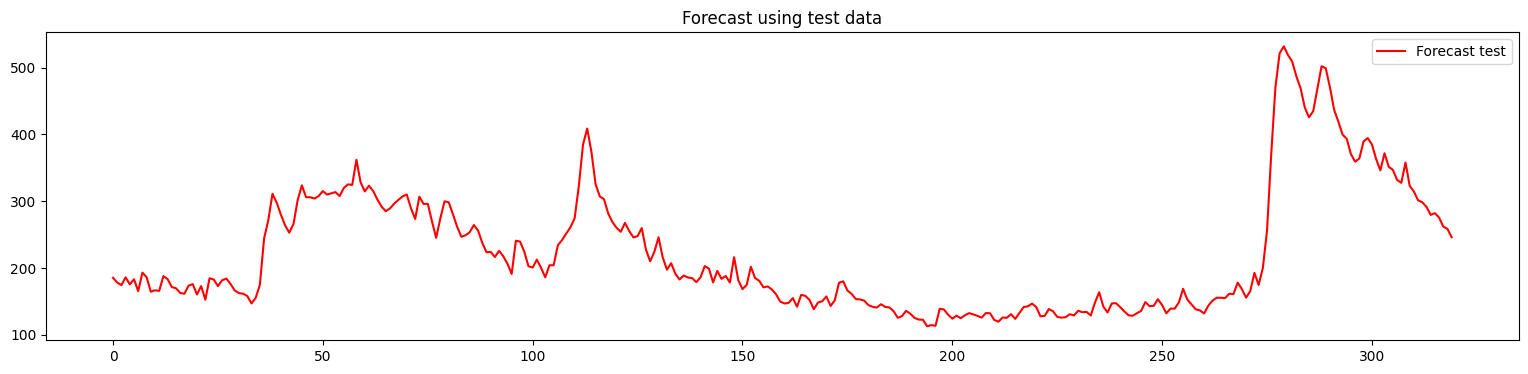

In [130]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, testPredict, 'red')
plt.legend(["Forecast test"])
plt.title("Forecast using test data")

Shift the predictions

In [73]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

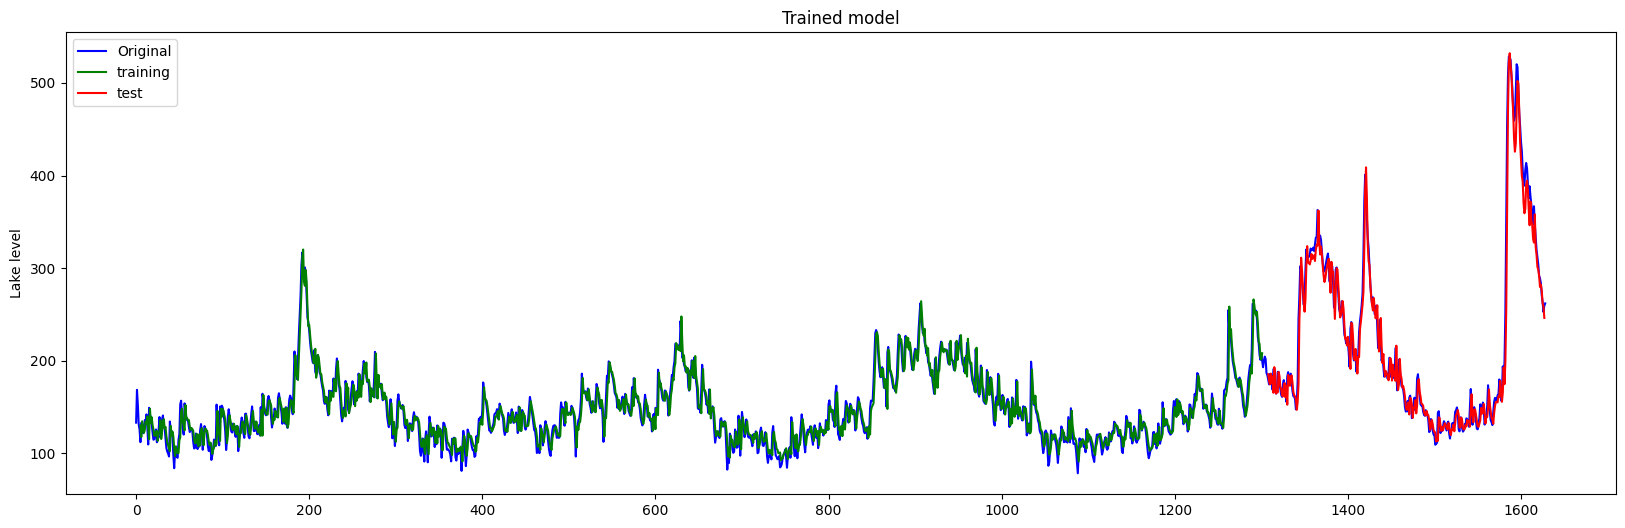

In [123]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

In [92]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.show()

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16'],
              dtype='datetime64[ns]', name='date_time', length=1629, freq='D')

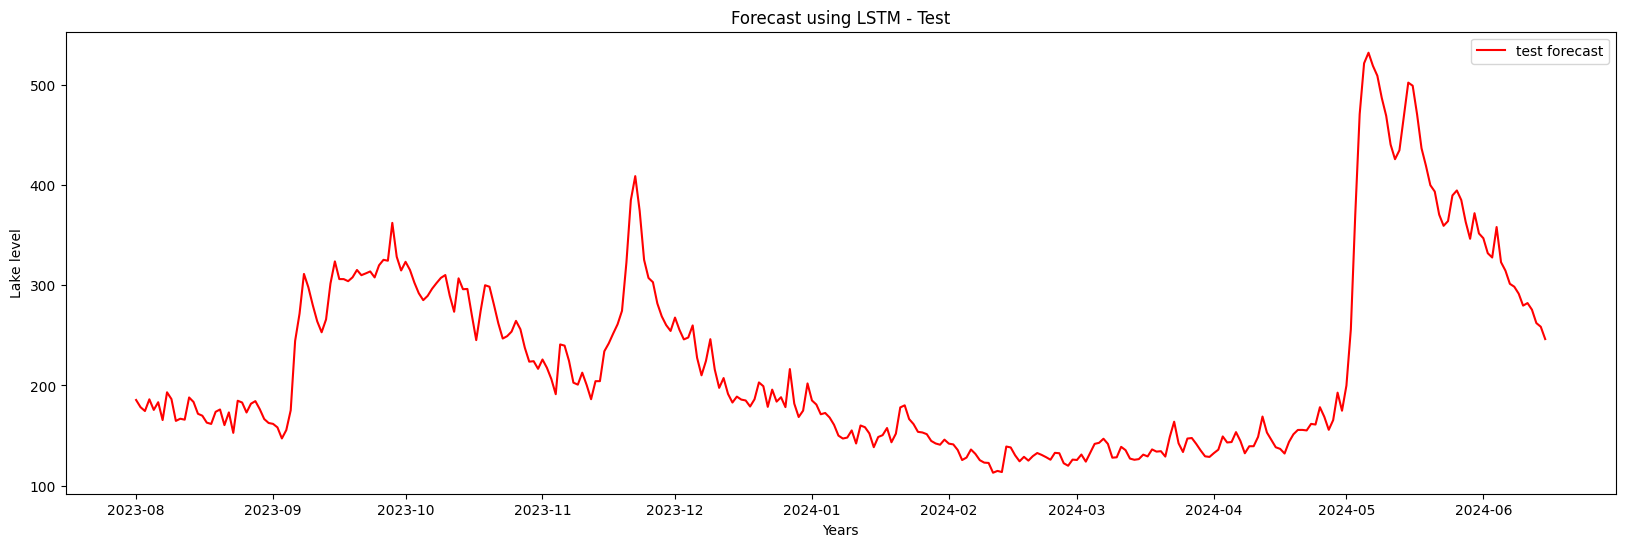

In [124]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(df_daily_mean.index, testPredictPlot, color='red')
plt.legend(["test forecast"])
plt.xlabel("Years")
plt.ylabel("Lake level")
plt.title("Forecast using LSTM - Test")
plt.show()